In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [3]:
file_path = 'screentime_analysis.csv'

In [9]:
screentime_data = pd.read_csv(file_path)

In [11]:
# Preprocessing
screentime_data['Date'] = pd.to_datetime(screentime_data['Date'])
screentime_data = screentime_data.sort_values(by='Date')
usage_data = screentime_data.groupby('Date')['Usage (minutes)'].sum().reset_index()

In [13]:
# Normalize the 'Usage (minutes)' column
scaler = MinMaxScaler(feature_range=(0, 1))
usage_data['Usage_scaled'] = scaler.fit_transform(usage_data[['Usage (minutes)']])


In [15]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Input sequence
        y.append(data[i + seq_length])   # Target value
    return np.array(X), np.array(y)

In [17]:
# Define sequence length
sequence_length = 5

In [19]:
# Generate sequences
X, y = create_sequences(usage_data['Usage_scaled'].values, sequence_length)

# Reshape for LSTM input (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [23]:
# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1), return_sequences=False),
    Dense(1)  # Output layer
])

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - loss: 0.1142 - val_loss: 0.1242
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0420 - val_loss: 0.1032
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0454 - val_loss: 0.0982
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0272 - val_loss: 0.1106
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0373 - val_loss: 0.1137
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0410 - val_loss: 0.1090
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0342 - val_loss: 0.1033
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0292 - val_loss: 0.1000
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0337 - val_loss: 0.0988
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0301 - val_loss: 0.1002
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0289 - val_loss: 0.1022
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0327 - val_loss: 0.1003


In [27]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss}")
print(f"Test Loss: {test_loss}")

Train Loss: 0.028755497187376022
Test Loss: 0.08669252693653107


In [29]:
# Make predictions
predictions = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


In [31]:
# Inverse transform predictions and actual values to original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_original = scaler.inverse_transform(predictions)

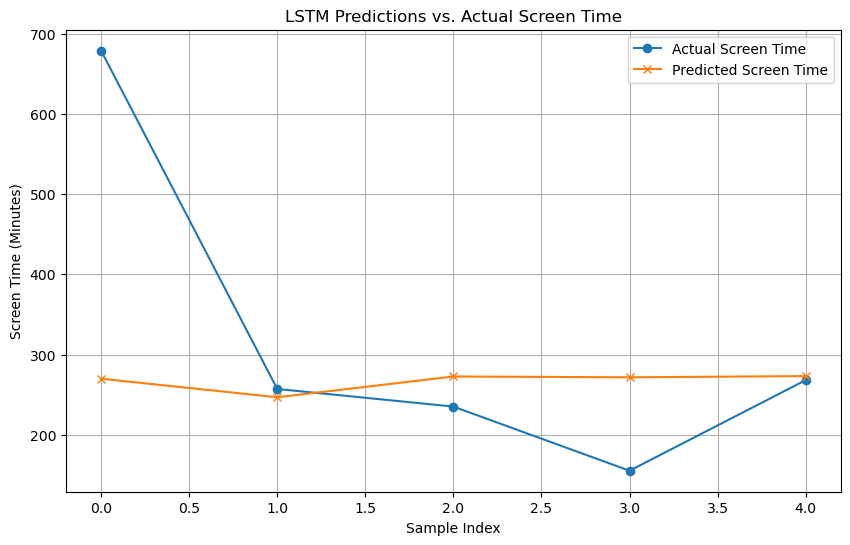

In [33]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Screen Time", marker='o')
plt.plot(predictions_original, label="Predicted Screen Time", marker='x')
plt.title("LSTM Predictions vs. Actual Screen Time")
plt.xlabel("Sample Index")
plt.ylabel("Screen Time (Minutes)")
plt.legend()
plt.grid()
plt.show()

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [37]:
# Calculate metrics
mae = mean_absolute_error(y_test_original, predictions_original)
rmse = np.sqrt(mean_squared_error(y_test_original, predictions_original))
r2 = r2_score(y_test_original, predictions_original)

In [39]:
# Print the metrics
print(f"Mean Absolute Error (MAE): {mae:.2f} minutes")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} minutes")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): 115.75 minutes
Root Mean Squared Error (RMSE): 191.09 minutes
R-squared (R²): -0.07
